# Capstone Project: Topic Modelling of Academic Journals (Model-Based Systems Engineering)

# 06: Classification Modeling

In this notebook, we will perform the following actions:
1. Classification Modeling
2. Future Works

The classfication model is important here as it would allow us to quickly label new published academic journals in the future.

## Import Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, \
f1_score, classification_report
from wordcloud import WordCloud

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Import Data

In [2]:
# Import the data for modelling
journals = pd.read_csv('../data/journals_topics.csv')

In [3]:
journals.head()

,title,abstract,year,tokens,topic,0,1,2,3,4,5,6,7
0,Model-based Design Process for the Early Phase...,This paper presents an approach for a model-ba...,2017,paper present approach planning process early ...,3,0.134677,0.049330,0.121864,0.157459,0.018720,0.165620,0.034708,0.056888
1,Model Based Systems Engineering using VHDL-AMS,The purpose of this paper is to contribute to ...,2013,purpose paper contribute definition ( ) approa...,6,0.166052,0.053813,0.101767,0.040338,0.025920,0.180074,0.204835,0.046355
2,Code Generation Approach Supporting Complex Sy...,Code generation is an effective way to drive t...,2022,code generation effective way drive complex de...,5,0.048002,0.023436,0.040045,0.012378,0.006812,0.110110,0.013624,0.015338
3,Model based systems engineering as enabler for...,"Product complexity is steadily increasing, cus...",2021,"product complexity steadily increasing , custo...",3,0.144370,0.045020,0.161951,0.335414,0.020165,0.169411,0.040359,0.061398
4,Electric Drive Vehicle Development and Evaluat...,To reduce development time and introduce techn...,2014,reduce development time introduce technology f...,0,0.487260,0.042662,0.097253,0.059448,0.029092,0.165888,0.037608,0.069110


In [4]:
journals['topic'].value_counts(normalize=True)

1    0.238824
0    0.205882
2    0.149412
3    0.136471
4    0.087059
5    0.077647
6    0.056471
7    0.048235
Name: topic, dtype: float64

In [5]:
journals['topic'].value_counts()

1    203
0    175
2    127
3    116
4     74
5     66
6     48
7     41
Name: topic, dtype: int64

## Preprocessing the Data by Topic

Here, we will preprocess the data once again by using CountVectorizer to tokenize and count our words. This is so that we can compare each topic for similar high frequency words. We will add these words as stop words so that our classification models can be trained on a more distinct set of words. 

In [6]:
# Define an empty list to store my topics
topic_dfs = []

# Iterate using a for loop to extra each topic and assign them into a separate dataframe
for topic_id in range(8):
    topic_dfs.append(journals.loc[journals['topic'] == topic_id])

topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7 = topic_dfs

# Create list containing all the topics dataframes
list_of_topics = [topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, 
                  topic_6, topic_7]

# Create empty list to store tokens for each topic
topic_tokens = []

# Iterate using a for loop to vectorize and store each topic tokens into a separate dataframe
for topic in list_of_topics:
    cvec = CountVectorizer(lowercase=False, ngram_range=(1,3))
    topic_matrix = cvec.fit_transform(topic['tokens'])
    topic_tokens_df = pd.DataFrame(topic_matrix.todense(), columns=cvec.get_feature_names_out())
    topic_tokens.append(topic_tokens_df)
    
topic_tokens_0, topic_tokens_1, topic_tokens_2, topic_tokens_3, topic_tokens_4, topic_tokens_5, topic_tokens_6, topic_tokens_7 = topic_tokens

## Visualize the High Frequency Words for Each Topic

Here, we will visualize the high frequency words for each topic, to identify common words between the topics. These common words will be added to our stop words.

In [7]:
# Create a dataframe with the top 50 words for each topic
top_50_words_topic_0 = topic_tokens_0.sum().sort_values(ascending=False).head(50)
top_50_words_topic_1 = topic_tokens_1.sum().sort_values(ascending=False).head(50)
top_50_words_topic_2 = topic_tokens_2.sum().sort_values(ascending=False).head(50)
top_50_words_topic_3 = topic_tokens_3.sum().sort_values(ascending=False).head(50)
top_50_words_topic_4 = topic_tokens_4.sum().sort_values(ascending=False).head(50)
top_50_words_topic_5 = topic_tokens_5.sum().sort_values(ascending=False).head(50)
top_50_words_topic_6 = topic_tokens_6.sum().sort_values(ascending=False).head(50)
top_50_words_topic_7 = topic_tokens_7.sum().sort_values(ascending=False).head(50)

In [8]:
# Convert the dataframes into sets of words
word_sets = [set(df.index) for df in [top_50_words_topic_0, top_50_words_topic_1, 
                                      top_50_words_topic_2, top_50_words_topic_3,
                                      top_50_words_topic_4, top_50_words_topic_5,
                                      top_50_words_topic_6, top_50_words_topic_7]]

# Find common words using set intersection
common_words = set.intersection(*word_sets)

# Print the common words
print(common_words)

{'method', 'approach', 'modeling', 'architecture', 'development', 'tool', 'paper', 'process', 'design'}


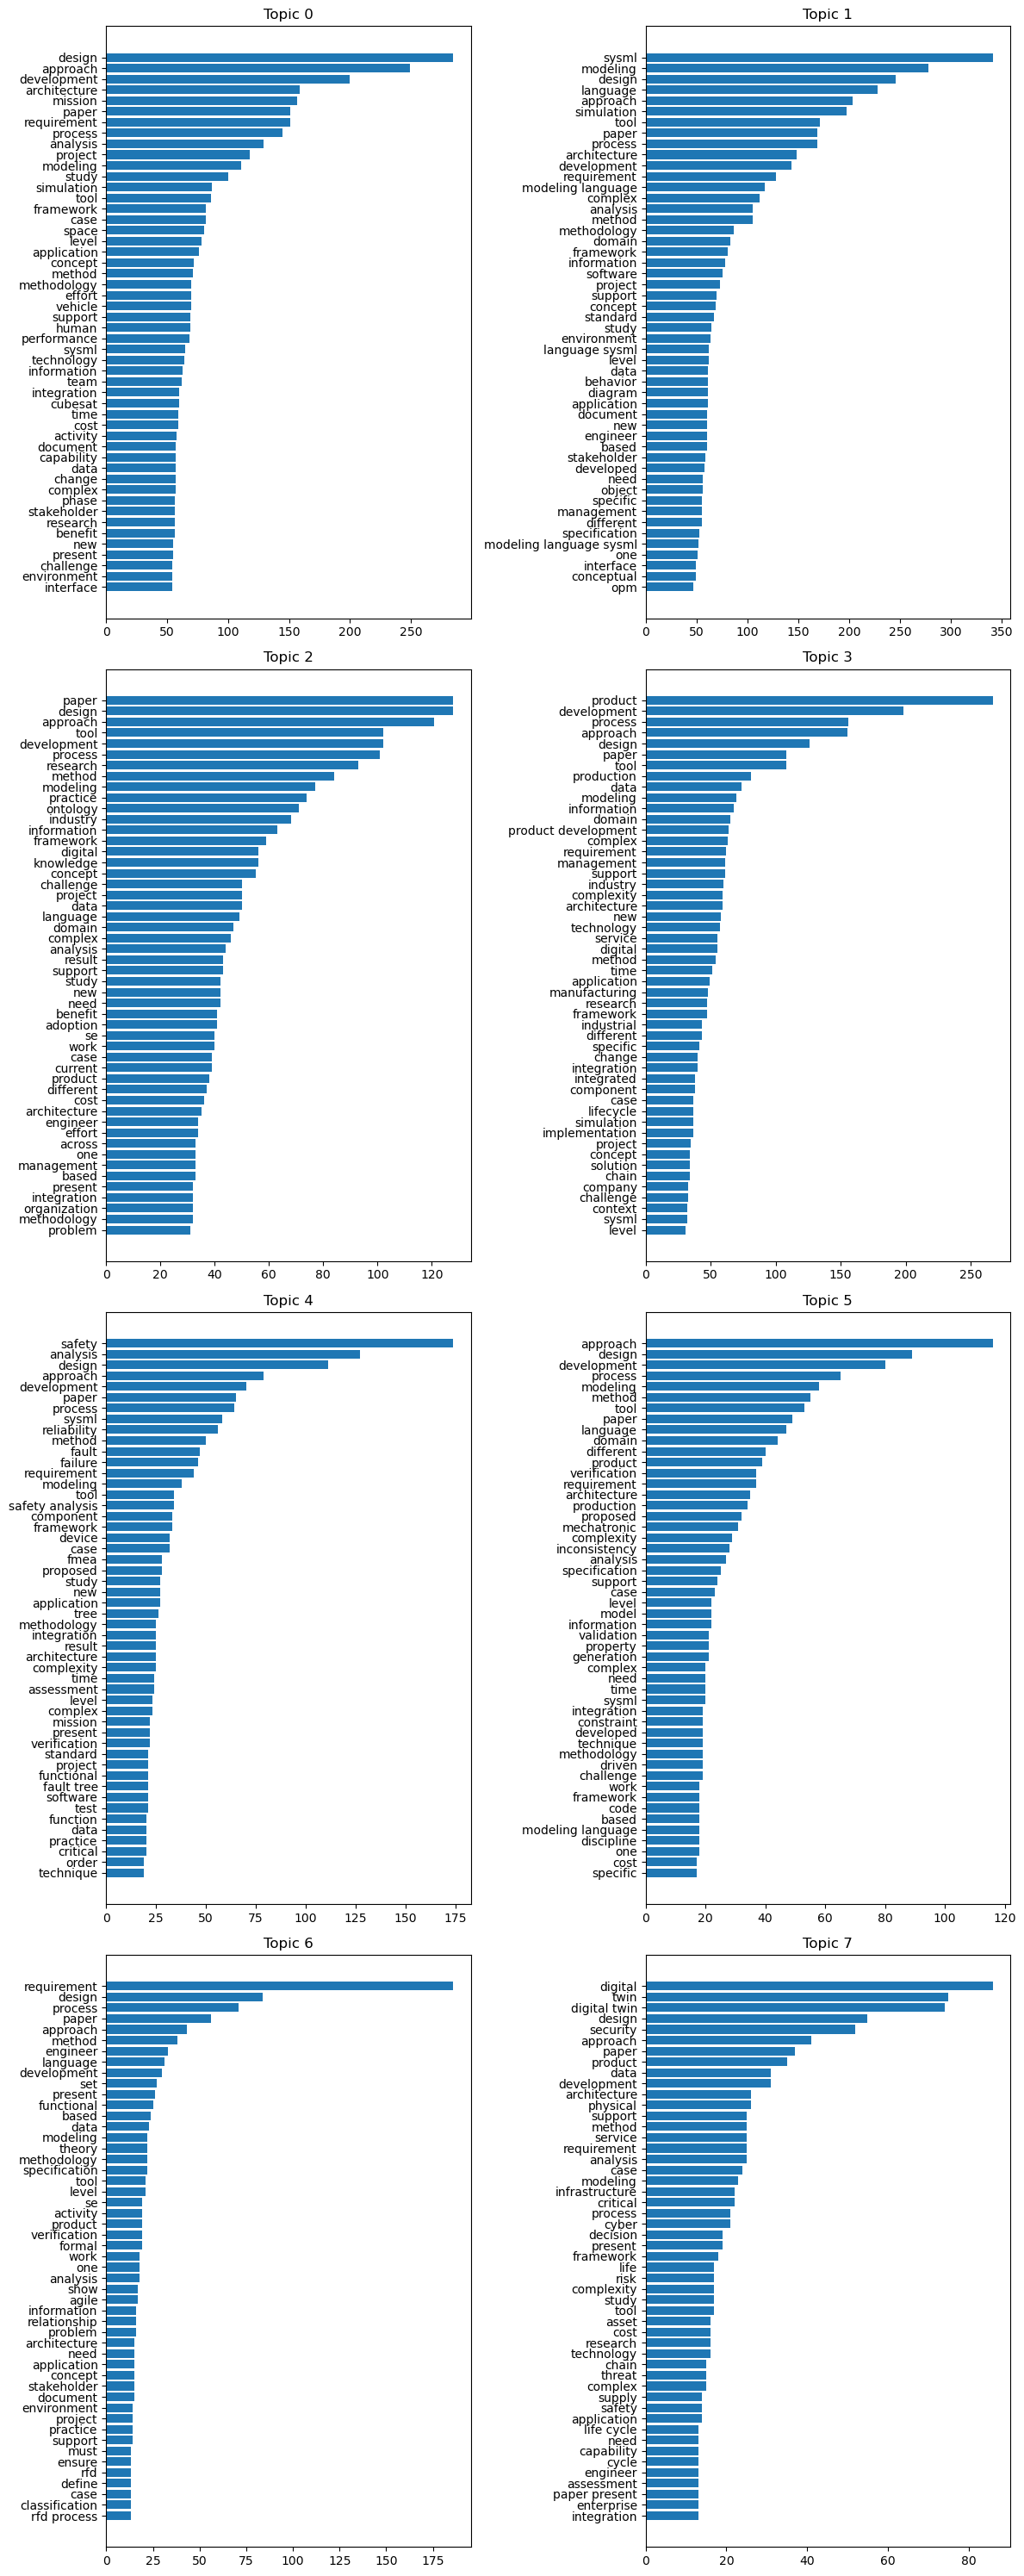

In [9]:
# Define the list of lists to plot
list_to_plot = [top_50_words_topic_0, top_50_words_topic_1, top_50_words_topic_2,
                top_50_words_topic_3, top_50_words_topic_4, top_50_words_topic_5,
                top_50_words_topic_6, top_50_words_topic_7]

# Create a 4x2 grid for the bar plots
fig, axes = plt.subplots(4, 2, figsize=(12, 30))

# Iterate over the list of lists and plot the bar plots
for i, ax in enumerate(axes.flatten()):
    sorted_data = list_to_plot[i].sort_values(ascending=True)
    ax.barh(sorted_data.index, sorted_data.values)
    ax.set_title(f'Topic {i}')
    ax.tick_params(axis='y', rotation=0)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Definition of Stop Words

Based on the data exploration above, we have identified some additional stop words to remove. This will make each topic more distinct to train the classification model.

In [10]:
# define the stop words
stop_words = ['tool', 'paper', 'method', 'architecture', 'design', 'modeling', 
              'development', 'approach', 'process']

## Train-Test Split

In [11]:
# Set up data for modeling
X = journals['tokens']
y = journals['topic']

In [12]:
# Check the distribution of the y values
y.value_counts()

1    203
0    175
2    127
3    116
4     74
5     66
6     48
7     41
Name: topic, dtype: int64

In [13]:
# Check the distribution of the y values
y.value_counts(normalize=True)

1    0.238824
0    0.205882
2    0.149412
3    0.136471
4    0.087059
5    0.077647
6    0.056471
7    0.048235
Name: topic, dtype: float64

As the data set is imbalanced, we will need to stratify it. 

In [14]:
# Split the data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    stratify = y, 
                                                    random_state=42)

Because our dataset is imbalanced, we will use SMOTE to oversample the minority classes.

## Classification Modeling

In this section, we'll begin with the classificatin modeling. 

## Model 0: Base Model

We will calculate the baseline score first. This is done by creating a dummy model to act as a baseline mode. All models trained later on can compare against this score to base its performance.

In [15]:
# Create dummy model to get baseline scores
dummy_class = DummyClassifier(strategy='stratified')

# Fit the model
dummy_class.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [16]:
# Make predictions on the test set
y_pred = dummy_class.predict(X_test)

# Evaluate the performance of the DummyClassifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.18      0.20        44
           1       0.23      0.25      0.24        51
           2       0.12      0.12      0.12        32
           3       0.11      0.10      0.11        29
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        16
           6       0.07      0.08      0.07        12
           7       0.12      0.20      0.15        10

    accuracy                           0.15       213
   macro avg       0.11      0.12      0.11       213
weighted avg       0.14      0.15      0.14       213



## Model 1: Naive Bayes Model (CountVectorizer)

The Naive Bayes model is a probabilistic classifier based on Bayes' theorem. It heavily relies on one simplifying assumption, which is that we assume our features are indepedent from one another. 

In [17]:
# Set up pipeline
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words, lowercase=False, 
                             ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())    
])

# Set up pipeline parameters
pipe_nb_cvec_params = {
    'cvec__max_features' : [250, 500, 1000, 2000],
    'nb__alpha' : [0.2, 0.5, 1],
    'nb__fit_prior' : [False, True]
}

# Perform gridsearch on the pipeline
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, pipe_nb_cvec_params, cv=5)

# Fit the model
gs_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False,
                                                        ngram_range=(1, 3),
                                                        stop_words=['tool',
                                                                    'paper',
                                                                    'method',
                                                                    'architecture',
                                                                    'design',
                                                                    'modeling',
                                                                    'development',
                                                                    'approach',
                                                                    'process'])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [250, 500, 1000, 2000],
                         'nb__alpha': [0.2, 0.5, 1],
                         'nb__fit_prior': [False, True]})

In [18]:
# Check what's the best parameters
gs_nb_cvec.best_params_

{'cvec__max_features': 2000, 'nb__alpha': 1, 'nb__fit_prior': False}

In [19]:
# Predict the classification on the test set
y_pred = gs_nb_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76        44
           1       0.74      0.82      0.78        51
           2       0.70      0.72      0.71        32
           3       0.68      0.86      0.76        29
           4       0.94      0.89      0.92        19
           5       0.71      0.62      0.67        16
           6       0.88      0.58      0.70        12
           7       0.88      0.70      0.78        10

    accuracy                           0.76       213
   macro avg       0.79      0.74      0.76       213
weighted avg       0.77      0.76      0.76       213



## Model 2: Naive Bayes Model (TF-IDF)

The Naive Bayes model is a probabilistic classifier based on Bayes' theorem. It heavily relies on one simplifying assumption, which is that we assume our features are indepedent from one another. 

In [21]:
# Set up pipeline
pipe_nb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())    
])

# Set up pipeline parameters
pipe_nb_tfidf_params = {
    'tfidf__max_features' : [250, 500, 1000],
    'nb__alpha' : [0.1, 0.2, 0.5, 1],
    'nb__fit_prior' : [False, True]
}

# Perform gridsearch on the pipeline
gs_nb_tfidf = GridSearchCV(pipe_nb_tfidf, pipe_nb_tfidf_params, cv=5)

# Fit the model
gs_nb_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.1, 0.2, 0.5, 1],
                         'nb__fit_prior': [False, True],
                         'tfidf__max_features': [250, 500, 1000]})

In [22]:
# Check what's the best parameters
gs_nb_tfidf.best_params_

{'nb__alpha': 1, 'nb__fit_prior': False, 'tfidf__max_features': 1000}

In [23]:
# Predict the classification on the test set
y_pred = gs_nb_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76        44
           1       0.74      0.82      0.78        51
           2       0.70      0.72      0.71        32
           3       0.68      0.86      0.76        29
           4       0.94      0.89      0.92        19
           5       0.71      0.62      0.67        16
           6       0.88      0.58      0.70        12
           7       0.88      0.70      0.78        10

    accuracy                           0.76       213
   macro avg       0.79      0.74      0.76       213
weighted avg       0.77      0.76      0.76       213



## Model 3: Logistic Regression (CountVectorizer)

The logistic regression gives us the probability of a feature being in each class by using a link function to "bend" of line of best fit into a curve of best fit to match the values we're interested in. This link funciton is known as the logit link.

In [24]:
# Set up pipeline
pipe_log_cvec = Pipeline([
    ('cvec', CountVectorizer(lowercase=False, ngram_range=(1,3))),
    #('smote', SMOTE(random_state=42)),
    ('log', LogisticRegression(solver='liblinear'))    
])

# Set up pipeline parameters
pipe_log_cvec_params = {
    'cvec__max_features' : [250, 500, 1000],
    'log__penalty' : ['l1', 'l2']
}

# Perform gridsearch on the pipeline
gs_log_cvec = GridSearchCV(pipe_log_cvec, pipe_log_cvec_params, cv=5)

# Fit the model
gs_log_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('log',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'cvec__max_features': [250, 500, 1000],
                         'log__penalty': ['l1', 'l2']})

In [25]:
# Check what's the best parameters
gs_log_cvec.best_params_

{'cvec__max_features': 1000, 'log__penalty': 'l2'}

In [26]:
# Predict the classification on the test set
y_pred = gs_log_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        44
           1       0.64      0.80      0.71        51
           2       0.70      0.72      0.71        32
           3       0.70      0.79      0.74        29
           4       0.80      0.63      0.71        19
           5       0.88      0.44      0.58        16
           6       0.83      0.83      0.83        12
           7       0.67      0.80      0.73        10

    accuracy                           0.71       213
   macro avg       0.75      0.71      0.71       213
weighted avg       0.73      0.71      0.71       213



## Model 4: Logistic Regression (TF-IDF)

The logistic regression gives us the probability of a feature being in each class by using a link function to "bend" of line of best fit into a curve of best fit to match the values we're interested in. This link funciton is known as the logit link.

In [27]:
# Set up pipeline
pipe_log_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('log', LogisticRegression(solver='liblinear'))     
])

# Set up pipeline parameters
pipe_log_tfidf_params = {
    'tfidf__max_features' : [250, 500, 1000],
    'log__penalty' : ['l1', 'l2']
}

# Perform gridsearch on the pipeline
gs_log_tfidf = GridSearchCV(pipe_log_tfidf, pipe_log_tfidf_params, cv=5)

# Fit the model
gs_log_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('log',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'log__penalty': ['l1', 'l2'],
                         'tfidf__max_features': [250, 500, 1000]})

In [28]:
# Check what's the best parameters
gs_log_tfidf.best_params_

{'log__penalty': 'l2', 'tfidf__max_features': 1000}

In [29]:
# Predict the classification on the test set
y_pred = gs_log_tfidf.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.64      0.69        44
           1       0.69      0.73      0.70        51
           2       0.74      0.72      0.73        32
           3       0.72      0.79      0.75        29
           4       0.94      0.79      0.86        19
           5       0.71      0.62      0.67        16
           6       0.67      0.83      0.74        12
           7       0.64      0.90      0.75        10

    accuracy                           0.73       213
   macro avg       0.73      0.75      0.74       213
weighted avg       0.73      0.73      0.73       213



## Model 5: K-Nearest Neighbors (CountVectorizer)

The KNN model is a non-parametric method that uses the nearest neighbor's classification to assign a class membership. 

In [30]:
# Set up pipeline
pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer(lowercase=False, ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())    
])

# Set up pipeline parameters
pipe_knn_cvec_params = {
    'cvec__max_features' : [250, 500, 1000],
    'knn__n_neighbors' : [5, 10, 15, 20, 25],
    'knn__p' : [1, 2]
}

# Perform gridsearch on the pipeline
gs_knn_cvec = GridSearchCV(pipe_knn_cvec, pipe_knn_cvec_params, cv=5)

# Fit the model
gs_knn_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_features': [250, 500, 1000],
                         'knn__n_neighbors': [5, 10, 15, 20, 25],
                         'knn__p': [1, 2]})

In [31]:
# Check what's the best parameters
gs_knn_cvec.best_params_

{'cvec__max_features': 250, 'knn__n_neighbors': 5, 'knn__p': 2}

In [32]:
# Predict the classification on the test set
y_pred = gs_knn_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.16      0.24        44
           1       0.75      0.18      0.29        51
           2       0.40      0.25      0.31        32
           3       0.48      0.34      0.40        29
           4       0.31      0.58      0.40        19
           5       0.17      0.50      0.25        16
           6       0.27      0.75      0.40        12
           7       0.28      0.80      0.41        10

    accuracy                           0.33       213
   macro avg       0.39      0.44      0.34       213
weighted avg       0.47      0.33      0.31       213



## Model 6: K-Nearest Neighbors (TF-IDF)

The KNN model is a non-parametric method that uses the nearest neighbor's classification to assign a class membership. 

In [33]:
# Set up pipeline
pipe_knn_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, ngram_range=(1,3))),
    #('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())     
])

# Set up pipeline parameters
pipe_knn_tfidf_params = {
    'tfidf__max_features' : [250, 500, 1000],
    'knn__n_neighbors' : [5, 10, 15, 20, 25],
    'knn__p' : [1, 2]
}

# Perform gridsearch on the pipeline
gs_knn_tfidf = GridSearchCV(pipe_knn_tfidf, pipe_knn_tfidf_params, cv=5)

# Fit the model
gs_knn_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 10, 15, 20, 25],
                         'knn__p': [1, 2],
                         'tfidf__max_features': [250, 500, 1000]})

In [34]:
# Check what's the best parameters
gs_knn_tfidf.best_params_

{'knn__n_neighbors': 10, 'knn__p': 2, 'tfidf__max_features': 1000}

In [35]:
# Predict the classification on the test set
y_pred = gs_knn_tfidf.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62        44
           1       0.58      0.71      0.64        51
           2       0.76      0.59      0.67        32
           3       0.64      0.86      0.74        29
           4       0.76      0.68      0.72        19
           5       0.62      0.31      0.42        16
           6       0.75      0.25      0.38        12
           7       0.73      0.80      0.76        10

    accuracy                           0.64       213
   macro avg       0.68      0.61      0.62       213
weighted avg       0.66      0.64      0.63       213



## Model 7: Random Forest (CountVectorizer)

The Random Forest Classifier is an emsemble method that combines the predictions of other smaller models. Each of the smaller model is a decision tree. 

In [36]:
# Set up pipeline
pipe_rf_cvec = Pipeline([
    ('cvec', CountVectorizer(lowercase=False, ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier())    
])

# Set up pipeline parameters
pipe_rf_cvec_params = {
    'cvec__max_features' : [250, 500, 1000],
    'rf__max_depth' : [1, 2, 3, 4, 5, 10, 15],
    'rf__n_estimators' : [100, 150, 200]
}

# Perform gridsearch on the pipeline
gs_rf_cvec = GridSearchCV(pipe_rf_cvec, pipe_rf_cvec_params, cv=5)

# Fit the model
gs_rf_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_features': [250, 500, 1000],
                         'rf__max_depth': [1, 2, 3, 4, 5, 10, 15],
                         'rf__n_estimators': [100, 150, 200]})

In [37]:
# Check what's the best parameters
gs_rf_cvec.best_params_

{'cvec__max_features': 500, 'rf__max_depth': 15, 'rf__n_estimators': 200}

In [38]:
# Predict the classification on the test set
y_pred = gs_rf_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.45      0.57        44
           1       0.67      0.73      0.70        51
           2       0.70      0.50      0.58        32
           3       0.61      0.66      0.63        29
           4       0.67      0.74      0.70        19
           5       0.35      0.44      0.39        16
           6       0.45      0.75      0.56        12
           7       0.59      1.00      0.74        10

    accuracy                           0.62       213
   macro avg       0.60      0.66      0.61       213
weighted avg       0.65      0.62      0.62       213



## Model 8: Random Forest (TF-IDF)

The Random Forest Classifier is an emsemble method that combines the predictions of other smaller models. Each of the smaller model is a decision tree. 

In [39]:
# Set up pipeline
pipe_rf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, ngram_range=(1,3))),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier())     
])

# Set up pipeline parameters
pipe_rf_tfidf_params = {
    'tfidf__max_features' : [250, 500],
    'rf__max_depth' : [1, 2, 3, 4, 5],
    'rf__n_estimators' : [100, 150, 200]
}

# Perform gridsearch on the pipeline
gs_rf_tfidf = GridSearchCV(pipe_rf_tfidf, pipe_rf_tfidf_params, cv=5)

# Fit the model
gs_rf_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5],
                         'rf__n_estimators': [100, 150, 200],
                         'tfidf__max_features': [250, 500]})

In [40]:
# Check what's the best parameters
gs_rf_tfidf.best_params_

{'rf__max_depth': 5, 'rf__n_estimators': 200, 'tfidf__max_features': 500}

In [41]:
# Predict the classification on the test set
y_pred = gs_rf_tfidf.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.61      0.61        44
           1       0.77      0.65      0.70        51
           2       0.61      0.59      0.60        32
           3       0.70      0.72      0.71        29
           4       0.77      0.89      0.83        19
           5       0.78      0.44      0.56        16
           6       0.50      0.92      0.65        12
           7       0.91      1.00      0.95        10

    accuracy                           0.68       213
   macro avg       0.70      0.73      0.70       213
weighted avg       0.69      0.68      0.68       213



## Model 9: Support Vector Machine (CountVectorizer)

The Support Vector Machine is a classification model that predicts the categorical vairables. They belong to a wider class of models called discriminant models. 

In [42]:
# Set up pipeline
pipe_svc_cvec = Pipeline([
    ('cvec', CountVectorizer(lowercase=False, ngram_range=(1,3))),
    #('smote', SMOTE(random_state=42)),
    ('svc', SVC())    
])

# Set up pipeline parameters
pipe_svc_cvec_params = {
    'cvec__max_features' : [250, 500, 1000],
    'svc__C' : [0.1, 1, 10, 50, 100]
}

# Perform gridsearch on the pipeline
gs_svc_cvec = GridSearchCV(pipe_svc_cvec, pipe_svc_cvec_params, cv=5)

# Fit the model
gs_svc_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_features': [250, 500, 1000],
                         'svc__C': [0.1, 1, 10, 50, 100]})

In [43]:
# Check what's the best parameters
gs_svc_cvec.best_params_

{'cvec__max_features': 1000, 'svc__C': 10}

In [44]:
# Predict the classification on the test set
y_pred = gs_svc_cvec.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.73      0.62        44
           1       0.59      0.75      0.66        51
           2       0.79      0.69      0.73        32
           3       0.73      0.76      0.75        29
           4       0.80      0.42      0.55        19
           5       0.67      0.25      0.36        16
           6       0.78      0.58      0.67        12
           7       1.00      0.60      0.75        10

    accuracy                           0.65       213
   macro avg       0.74      0.60      0.64       213
weighted avg       0.68      0.65      0.65       213



## Model 10: Support Vector Machine (TF-IDF)

The Support Vector Machine is a classification model that predicts the categorical vairables. They belong to a wider class of models called discriminant models. 

In [45]:
# Set up pipeline
pipe_svc_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, ngram_range=(1,3))),
    #('smote', SMOTE(random_state=42)),
    ('svc', SVC())     
])

# Set up pipeline parameters
pipe_svc_tfidf_params = {
    'tfidf__max_features' : [250, 500, 1000],
    'svc__C' : [0.1, 1, 10, 50, 100]
}

# Perform gridsearch on the pipeline
gs_svc_tfidf = GridSearchCV(pipe_svc_tfidf, pipe_svc_tfidf_params, cv=5)

# Fit the model
gs_svc_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        ngram_range=(1, 3))),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 50, 100],
                         'tfidf__max_features': [250, 500, 1000]})

In [46]:
# Check what's the best parameters
gs_svc_tfidf.best_params_

{'svc__C': 10, 'tfidf__max_features': 500}

In [47]:
# Predict the classification on the test set
y_pred = gs_svc_tfidf.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69        44
           1       0.56      0.76      0.64        51
           2       0.81      0.81      0.81        32
           3       0.75      0.83      0.79        29
           4       0.83      0.53      0.65        19
           5       0.80      0.25      0.38        16
           6       0.80      0.33      0.47        12
           7       1.00      0.80      0.89        10

    accuracy                           0.69       213
   macro avg       0.78      0.63      0.66       213
weighted avg       0.72      0.69      0.68       213



## Model Evaluation

|Model   | Model Type          |Precision |Recall | F1 | 
|------------|---------------------|----|----------|-------------|
|Model 0     |Dummy Classifier     |0.14|0.13|0.14|
|Model 1     |Naive Bayes (Cvec)   |0.79|0.74|0.76|
|Model 2     |Naive Bayes (TF-IDF) |0.79|0.74|0.76|
|Model 3     |Logistic Regression (Cvec)|0.75|0.71|0.71|
|Model 4     |Logistic Regression (TF-IDF)|0.73|0.75|0.74|
|Model 5     |KNN Classifier (Cvec)|0.39|0.44|0.34|
|Model 6     |KNN Classifier (TF-IDF)|0.68|0.61|0.62|
|Model 7     |Random Forest (Cvec)|0.63|0.67|0.63|
|Model 8     |Random Forest (TF-IDF)|0.67|0.71|0.67|
|Model 9     |Support Vector Machine (Cvec)|0.74|0.60|0.64|
|Model 10    |Support Vector Machine (TF-IDF)|0.78|0.63|0.66|

As all our classes are important, we will be using the macro average F1 score to identify the best performing model. Furthermore, the macro average is used compared to the weighted average as this score method will heavily penalize the minority classes if the model does not perform well. This is because we are using an imbalanced dataset and we expect the minority classes to not perform as well as the majority class.  

### Best Performing Model (Naive Bayes)

From the F1 scores, we can tell that the Naive Bayes model performs the best, with an F1 score of 0.76. This is followed by the Logistic Regression Model, which has an F1 score of 0.74. As such, we will choose the **Naive Bayes** model as our production model and further explore it by looking at the confusion matrix.

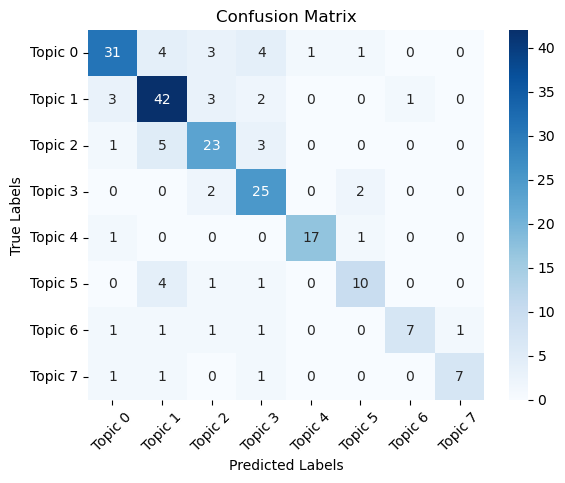

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (if available)
class_labels = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']

# Plot confusion matrix
#plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('True Labels')
plt.title('Confusion Matrix');
#plt.show()

From the above confusion matrix and the F1 score of 0.76, we can conclude that the classification model is pretty decent, especially since we have a relatively small dataset. 

## Future Works

As part of our future works, we would like to create a front-end implementation of the classification model. This would allow us to quickly pre-process and label newly published without having to open our jupyter notebooks.